In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

#load dataset
ames_data = pd.read_csv('Ames_HousePrice.csv')
ames_data.head()

# XGBoost Preprocessing

# Copy dataset for XGBoost model
ames_xgb = ames_data.copy()


# List of numerical columns to scale (excluding one-hot encoded and ID columns)
numerical_cols = ames_xgb.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Drop high-missing columns
high_missing_cols = ["PoolQC", "MiscFeature", "Alley", "Fence"]
ames_xgb.drop(columns=high_missing_cols, inplace=True)

# Fill categorical NaNs with "None"
categorical_cols = ames_xgb.select_dtypes(include=["object"]).columns
ames_xgb[categorical_cols] = ames_xgb[categorical_cols].fillna("None")

# Fill numerical NaNs with median
num_imputer = SimpleImputer(strategy="median")
ames_xgb[numerical_cols] = num_imputer.fit_transform(ames_xgb[numerical_cols])

# Log transformation of SalePrice
ames_xgb["SalePrice"] = np.log(ames_xgb["SalePrice"])

# Remove outliers (GrLivArea > 4000)
ames_xgb = ames_xgb[ames_xgb["GrLivArea"] < 4000]

# Feature Engineering: TotalSF and HouseAge
ames_xgb['TotalSqFt'] = ames_xgb['GrLivArea'] + ames_xgb['TotalBsmtSF']
ames_xgb['HouseAge'] = ames_xgb['YrSold'] - ames_xgb['YearBuilt']
ames_xgb['YearsSinceRemodel'] = ames_xgb['YrSold'] - ames_xgb['YearRemodAdd']
ames_xgb['TotalBath'] = ames_xgb['FullBath'] + ames_xgb['HalfBath'] + ames_xgb['BsmtFullBath'] + ames_xgb['BsmtHalfBath']
ames_xgb['Porch'] = ames_xgb['WoodDeckSF'] + ames_xgb['OpenPorchSF'] + ames_xgb['EnclosedPorch'] + ames_xgb['3SsnPorch'] + ames_xgb['ScreenPorch']
ames_xgb.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1, inplace=True)

# Convert categorical variables to ordinal encoding
for col in categorical_cols:
    ames_xgb[col] = ames_xgb[col].astype("category").cat.codes

# XGBoost Model
import xgboost as xgb

# Define features and target variable
X_xgb = ames_xgb.drop(columns=["SalePrice"])  # Preprocessed XGBoost data (ordinal encoding)
y_xgb = ames_xgb["SalePrice"].values  # Log-transformed SalePrice

# Split data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

# Define the model
from xgboost import XGBRegressor
xgboost = XGBRegressor()

# Set up the parameter grid
xgb_param_grid = {
    'n_estimators': [300, 500, 1100],
    'max_depth': [2, 3, ],
    'learning_rate': [0.1, 0.3, 0.5]
}

# Set up the grid search
xgb_grid_search = GridSearchCV(xgboost, xgb_param_grid, cv=5, scoring='r2', verbose=1)
xgb_grid_search.fit(X_train_xgb, y_train_xgb)

# Best parameters and best score
print("Best parameters:", xgb_grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(xgb_grid_search.best_score_))

# Retrain models with the best parameters
models = {
    'XGBoost': XGBRegressor(**xgb_grid_search.best_params_)
}

# Dictionary to store evaluation metrics
model_metrics = {}

# Train each model and evaluate on the test set
for name, model in models.items():
    model.fit(X_train_xgb, y_train_xgb)  # Train model
    y_pred = model.predict(X_test_xgb)  # Predict on test set
    # Calculate R^2 and RMSE
    r2 = r2_score(y_test_xgb, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_xgb, y_pred))
    # Store metrics
    model_metrics[name] = {'R^2': r2}
    
print(f"XGBoost Model -> R^2: {r2:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1100}
Best cross-validation score: 0.9164
XGBoost Model -> R^2: 0.9479


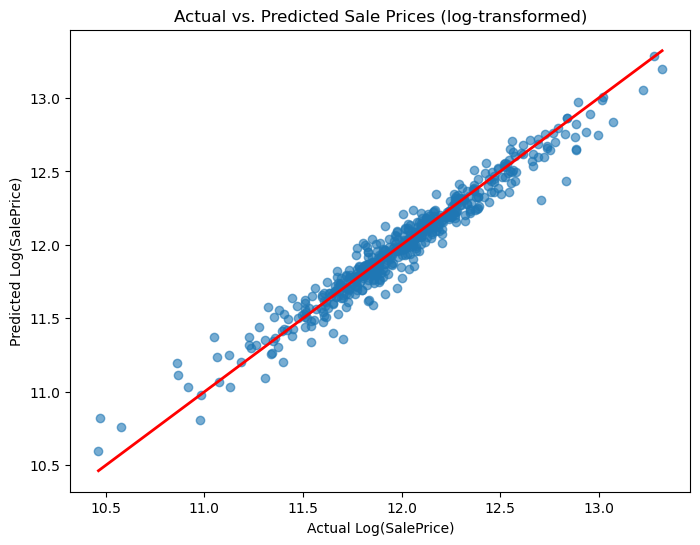

In [24]:
import matplotlib.pyplot as plt

# Using the XGBoost model as an example
xgb_model = models['XGBoost']
y_pred = xgb_model.predict(X_test_xgb)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_xgb, y_pred, alpha=0.6)
plt.xlabel("Actual Log(SalePrice)")
plt.ylabel("Predicted Log(SalePrice)")
plt.title("Actual vs. Predicted Sale Prices (log-transformed)")
plt.plot([min(y_test_xgb), max(y_test_xgb)], [min(y_test_xgb), max(y_test_xgb)], color='red', lw=2)  # Diagonal line
plt.show()


In [26]:
cv_results = xgb_grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"Mean R²: {mean_score:.4f} for parameters: {params}")


Mean R²: 0.9136 for parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}
Mean R²: 0.9151 for parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}
Mean R²: 0.9164 for parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1100}
Mean R²: 0.9131 for parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Mean R²: 0.9139 for parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Mean R²: 0.9129 for parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1100}
Mean R²: 0.9062 for parameters: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 300}
Mean R²: 0.9059 for parameters: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 500}
Mean R²: 0.9044 for parameters: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 1100}
Mean R²: 0.9053 for parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}
Mean R²: 0.9041 for parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_est

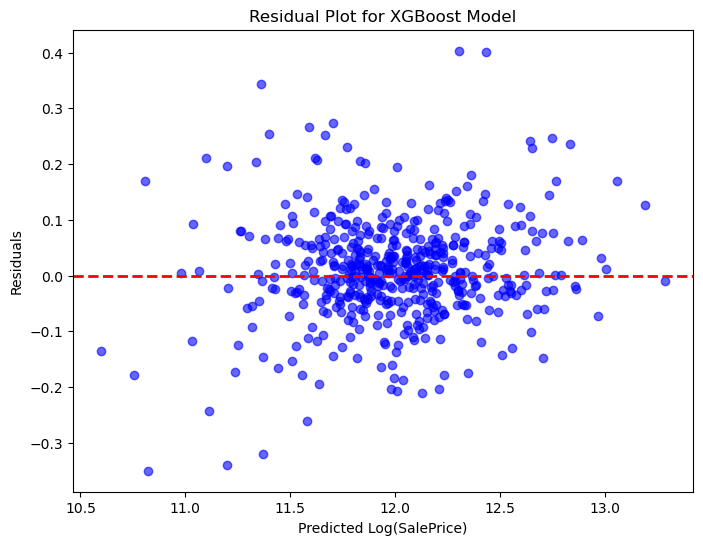

In [28]:
import matplotlib.pyplot as plt

# Assuming you've already trained your XGBoost model
xgb_model = models['XGBoost']
y_pred = xgb_model.predict(X_test_xgb)

# Calculate residuals: actual - predicted
residuals = y_test_xgb - y_pred

# Create the residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Log(SalePrice)")
plt.ylabel("Residuals")
plt.title("Residual Plot for XGBoost Model")
plt.show()

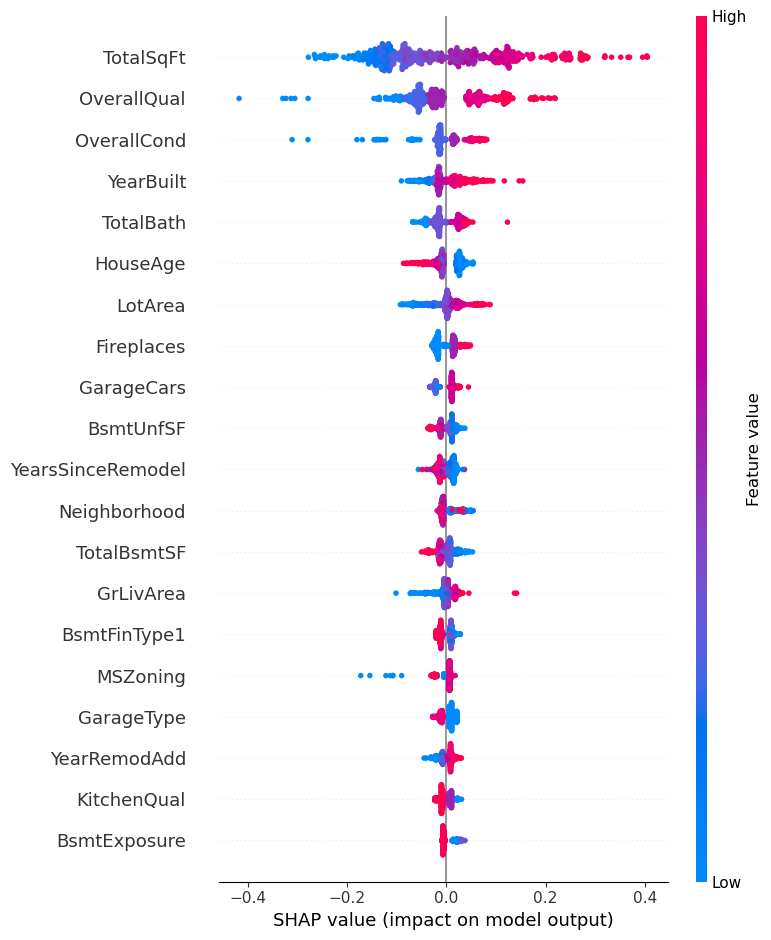

In [30]:
import shap

# Create an explainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_xgb)

# Summary plot to visualize feature importance and effects
shap.summary_plot(shap_values, X_test_xgb)